In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.layers import Input, concatenate, add
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [9]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17377678458821952361,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4794178397858980996
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [10]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7348158623614099793,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17770303041405951823
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [11]:
train_path='D:\DUmDum\deepfakes\dataset\Train'
valid_path='D:\DUmDum\deepfakes\dataset\Validation'
test_path='D:\DUmDum\deepfakes\dataset\Test'

In [12]:
train_batches = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(directory=train_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
valid_batches = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(directory=valid_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(directory=test_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [13]:
assert train_batches.n == 140002
assert valid_batches.n == 39428
assert test_batches.n == 10905
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [14]:
train_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
imgs, labels =next(train_batches)

In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

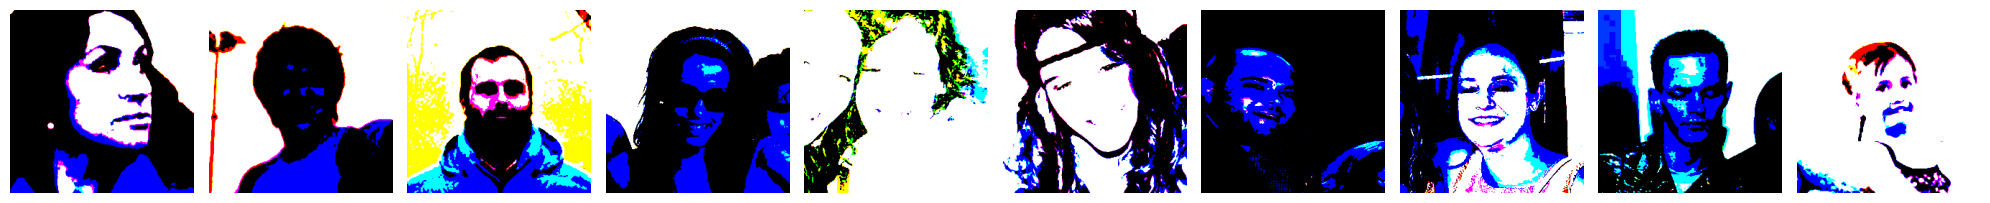

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [17]:
plotImages(imgs)
print(labels)

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

# Input layer
input_layer = Input(shape=(256,256,3))

# InceptionV3 model
inception_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)

# ResNet50 model
resnet_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)

# Flatten layers for both models
inception_flatten = Flatten()(inception_model.output)
resnet_flatten = Flatten()(resnet_model.output)

# Concatenate the two flatten layers
merged = concatenate([inception_flatten, resnet_flatten])

# Dropout layer
x = Dropout(0.5)(merged)

# Output layer
output_layer = Dense(2, activation='softmax')(x)

# Combined model
model = Model(inputs=input_layer, outputs=output_layer)

# Freeze layers of InceptionV3 model
for layer in inception_model.layers:
    layer.trainable = False

# Freeze layers of ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False

# Set up SGD optimizer with a learning rate of 0.001
sgd = SGD(lr=0.001)

# Compile the model with SGD optimizer
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()




Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

D:\anaconda3\envs\tff-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [20]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [21]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11328456094088584120,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2160159868916683538
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [24]:
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=1)

Epoch 1/10
14001/14001 [==============================] - 2332s 165ms/step - loss: 3159.4158 - accuracy: 0.6704 - val_loss: 1826.1921 - val_accuracy: 0.7420
Epoch 2/10
14001/14001 [==============================] - 2276s 163ms/step - loss: 2689.3059 - accuracy: 0.7227 - val_loss: 2097.6943 - val_accuracy: 0.7523
Epoch 3/10
14001/14001 [==============================] - 2261s 161ms/step - loss: 2520.4175 - accuracy: 0.7427 - val_loss: 2045.1362 - val_accuracy: 0.7308
Epoch 4/10
14001/14001 [==============================] - 2257s 161ms/step - loss: 2377.5085 - accuracy: 0.7548 - val_loss: 1336.3636 - val_accuracy: 0.8040
Epoch 5/10
14001/14001 [==============================] - 2258s 161ms/step - loss: 2271.8284 - accuracy: 0.7644 - val_loss: 2508.1028 - val_accuracy: 0.7053
Epoch 6/10
14001/14001 [==============================] - 2270s 162ms/step - loss: 2184.9458 - accuracy: 0.7719 - val_loss: 1259.9366 - val_accuracy: 0.8039
Epoch 7/10
14001/14001 [==============================] - 

In [25]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

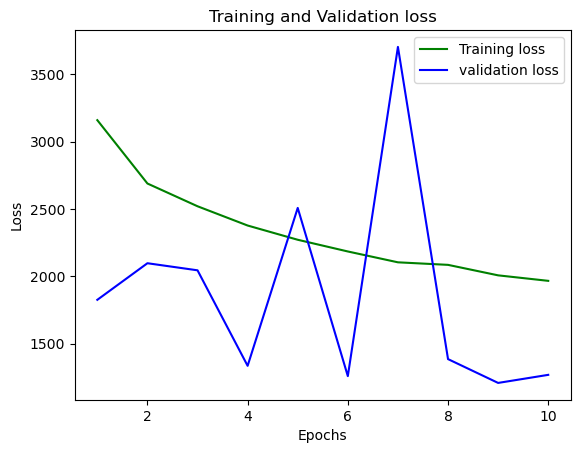

In [26]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

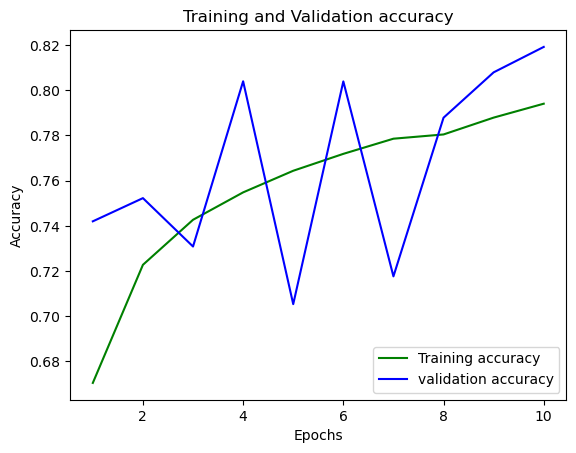

In [29]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
model.metrics_names

['loss', 'accuracy']

In [31]:
predictions = model.predict(x=test_batches,verbose=1)

1091/1091 [==============================] - 138s 124ms/step


In [32]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [33]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [34]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix,without normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

In [35]:
test_batches.class_indices

{'Fake': 0, 'Real': 1}

Confusion Matrix,without normalization
[[2415 3077]
 [2403 3010]]


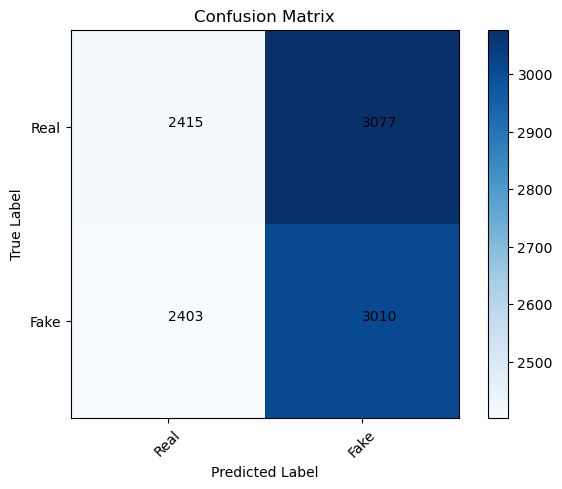

In [36]:
cm_plot_labels=['Real','Fake']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [37]:
#import os.path
#if os.path.isfile('D:\DUmDum\deepfakes\DFmodel\DF.h5') is False:
    #model.save('D:\DUmDum\deepfakes\DFmodel\df2.h5')

In [38]:
from sklearn.metrics import accuracy_score, classification_report

In [39]:
#classification_report(test_batches.classes , np.round(predictions))